In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import os

<ipython-input-1-1be51652f34e>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [9]:
path = os.getcwd()[:-10] + '/raw_data/' + 'DG.PA.csv'

In [10]:
data  = pd.read_csv(path)

In [11]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-06-07,67.099998,67.470001,66.889999,66.900002,57.535126,1839903
1,2016-06-08,66.620003,66.790001,66.040001,66.150002,56.890114,1665028
2,2016-06-09,66.160004,66.160004,65.519997,65.790001,56.580502,1436405
3,2016-06-10,65.550003,65.550003,64.620003,64.669998,55.617290,1567479
4,2016-06-13,64.139999,64.440002,63.650002,63.650002,54.740074,1964753


In [12]:
data = data[['Date', 'Adj Close']]
data.head()

,Date,Adj Close
0,2016-06-07,57.535126
1,2016-06-08,56.890114
2,2016-06-09,56.580502
3,2016-06-10,55.617290
4,2016-06-13,54.740074


In [184]:
data[1021:]

,Date,Adj Close
1021,2020-06-04,85.215424
1022,2020-06-05,87.026871
1023,2020-06-08,86.333122
1024,2020-06-09,84.155525
1025,2020-06-10,82.671684
...,...,...
1274,2021-05-31,92.919998
1275,2021-06-01,93.959999
1276,2021-06-02,93.870003
1277,2021-06-03,93.449997


In [193]:
# for computational optimization we decide to keep only the last year 
y = data['Adj Close'][1021:].reset_index(drop=True)

In [194]:
y

0      85.215424
1      87.026871
2      86.333122
3      84.155525
4      82.671684
         ...    
253    92.919998
254    93.959999
255    93.870003
256    93.449997
257    93.449997
Name: Adj Close, Length: 258, dtype: float64

<AxesSubplot:>

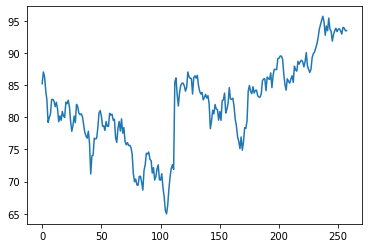

In [195]:
y.plot()

In [20]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import itertools
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [234]:
# all the possibilities to test
range_p = [0,1,2]
range_d = [1]
range_q = [0,1,2]
# build all the possibilities 
grid = itertools.product(range_p, range_d, range_q)

# empty lists to store results 
orders = []
mapeS = []
aics = []
fold_idxs = []
list_y_pred = []
list_y_test = []
baseline = []
base_score = []
real_value = []

# for all possibilities (pdq) create splits in our TS
for (p,d,q) in grid:
    order = (p,d,q)
    # make the split of the indexes of our TS
    folds = TimeSeriesSplit(n_splits=5, 
                            max_train_size=25, test_size=1)
    
    # fold_idx is the number of the split -- n_splits ?  
    # train_idx are the indexes of the split n°X
    # same for test_idx
    # y[:-1] because we need the y_true known 
    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(y)):
        # we store the number of the split executed
        fold_idxs.append(fold_idx)
        # we retrieve the real data in y 
        #corresponding of the indexes splited 
        y_train = y[train_idx]
        y_test = y[test_idx]
        y_true = y[test_idx]
        base = y_train.iloc[-1]
        
        try: 
            # fit our model on y_train of the split n°X
            model = ARIMA(y_train, order=order).fit()
            # we find our y_pred 
            y_pred = model.forecast(len(y_test))[0]
            mapeS.append(MAPE(y_pred, y_true))
            orders.append(order)
            aics.append(model.aic)
            list_y_pred.append(y_pred[0])
            list_y_test.append(y_test[test_idx])
            baseline.append(base)
            base_score.append(MAPE(np.array([base]), y_true))
            real_value.append(y_true.values[0])
            
        except:
            pass
        
        
model_results = pd.DataFrame(list(zip(fold_idxs, orders, aics, mapeS, list_y_pred, baseline, base_score, real_value)),#, r2s)), 
                   columns =['Fold', '(p,d,q)', 'AIC', 'MAPE', 'Pred', 'Baseline', 'base_score', 'True'])



/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.AR

/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/bas

/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/ari

/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/ari

/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/ari

/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/ari

/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/ari

/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/arnaudraybaud/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnin

In [235]:
y_true

257    93.449997
Name: Adj Close, dtype: float64

In [236]:
y_pred

array([94.36979797])

In [237]:
base

93.449997

In [207]:
model_results.sort_values('AIC').groupby('(p,d,q)').mean()['AIC'].sort_values()



(p,d,q)
(0, 1, 0)    89.355249
(0, 1, 1)    90.642153
(1, 1, 0)    90.812307
(1, 1, 1)    91.206320
(0, 1, 2)    91.630570
(2, 1, 0)    92.278028
(1, 1, 2)    92.605961
(2, 1, 1)    92.904788
(2, 1, 2)    93.945839
Name: AIC, dtype: float64

In [208]:
model_results[0:30]

,Fold,"(p,d,q)",AIC,MAPE,Pred,Baseline,base_score,True
0,0,"(0, 1, 0)",65.542447,0.005829,80.653480,80.906921,0.008944,80.183319
1,1,"(0, 1, 0)",68.234558,0.001051,79.903758,80.183319,0.002439,79.987755
2,2,"(0, 1, 0)",70.779265,0.032893,79.712615,79.987755,0.029340,82.334579
3,3,"(0, 1, 0)",76.488292,0.001103,82.190537,82.334579,0.002850,82.099899
4,4,"(0, 1, 0)",79.091854,0.008492,81.951541,82.099899,0.006670,82.647484
5,5,"(0, 1, 0)",81.874570,0.010671,82.530759,82.647484,0.012068,81.650085
6,6,"(0, 1, 0)",84.773179,0.025695,81.495070,81.650085,0.027545,79.401039
7,7,"(0, 1, 0)",89.400477,0.016951,79.158773,79.401039,0.019951,77.816933
8,8,"(0, 1, 0)",87.947630,0.016574,77.433186,77.816933,0.011561,78.716553
9,9,"(0, 1, 0)",88.683212,0.022757,78.399196,78.716553,0.018634,80.183319


In [209]:
ecart = (model_results['MAPE'] - model_results['base_score'])**2
ecart.mean()

4.069881773080648e-05

In [210]:
model_results.sort_values('MAPE').groupby('(p,d,q)').mean()['MAPE'].sort_values()



(p,d,q)
(0, 1, 0)    0.014364
(1, 1, 0)    0.014863
(0, 1, 1)    0.015138
(2, 1, 0)    0.015302
(2, 1, 1)    0.015607
(1, 1, 1)    0.015733
(1, 1, 2)    0.016212
(2, 1, 2)    0.016422
(0, 1, 2)    0.016453
Name: MAPE, dtype: float64

In [221]:
import math
test = [0,1,2,3,4]
test = np.array(test)
test.mean()

2.0

In [ ]:
# empty lists to store results 
import ipdb

mapeS = []
aics = []
fold_idxs = []
list_y_pred = []
list_y_test = []
baseline = []
base_score = []
real_value = []
model_results_max = []

# we search all the possibilities for max_train 
for max_train in range(2,35,1) :

    #splits = len(y) - max_train

    order = (0,1,0)
    # make the split of the indexes of our TS
    folds = TimeSeriesSplit(n_splits=200, 
                            max_train_size=max_train, test_size=1)

    # fold_idx is the number of the split -- n_splits ?  
    # train_idx are the indexes of the split n°X
    # same for test_idx
    
    for train_idx, test_idx in folds.split(y):
        
        # we retrieve the real data in y 
        #corresponding of the indexes splited 
        y_train = y[train_idx]
        y_test = y[test_idx]
        y_true = y[test_idx]
        base = y_train.iloc[-1]
        ipdb.set_trace()
        try: 
            # fit our model on y_train of the split n°X
            model = ARIMA(y_train, order=order).fit()
            # we find our y_pred 
            y_pred = model.forecast(len(y_test))[0]
            mapeS.append(MAPE(y_pred, y_true))
            
            # need np.array to compute mean
            base_score.append(MAPE(np.array([base]), y_true))
            
            
        except:
            pass
    
    mapeS = np.array(mapeS)
    base_score = np.array(base_score)
    # we store all the results 
    #ipdb.set_trace()
    model_results_max.append([max_train, mapeS[0], base_score[0]])
                                                 
      

In [262]:
for train_idx, test_idx in folds.split(y):
    print(len(train_idx))

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [248]:
y_pred

array([94.36979797])

In [260]:
MAPE(y_pred, y_true)

0.0011045380414242668

In [261]:
MAPE(np.array([base]), y_true)

0.0

In [259]:
mapeS

array([], dtype=float64)

In [242]:
splits

224

In [246]:
mapes = np.array(mapeS)
mapes.mean()

0.005516406563070417

In [256]:
model_results_max

[[2, 224, nan, nan],
 [3, 224, nan, nan],
 [4, 224, nan, nan],
 [5, 224, nan, nan],
 [6, 224, nan, nan],
 [7, 224, nan, nan],
 [8, 224, nan, nan],
 [9, 224, nan, nan],
 [10, 224, nan, nan],
 [11, 224, nan, nan],
 [12, 224, nan, nan],
 [13, 224, nan, nan],
 [14, 224, nan, nan],
 [15, 224, nan, nan],
 [16, 224, nan, nan],
 [17, 224, nan, nan],
 [18, 224, nan, nan],
 [19, 224, nan, nan],
 [20, 224, nan, nan],
 [21, 224, nan, nan],
 [22, 224, nan, nan],
 [23, 224, nan, nan],
 [24, 224, nan, nan],
 [25, 224, nan, nan],
 [26, 224, nan, nan],
 [27, 224, nan, nan],
 [28, 224, nan, nan],
 [29, 224, nan, nan],
 [30, 224, nan, nan],
 [31, 224, nan, nan],
 [32, 224, nan, nan],
 [33, 224, nan, nan],
 [34, 224, nan, nan]]

In [214]:
model_results_max[0:30]

,Fold,AIC,MAPE,Pred,Baseline,base_score,True
0,0,109.672071,0.002707,81.891309,82.002113,0.004054,81.669640
1,1,107.921029,0.010453,81.484908,81.669640,0.012692,80.633125
2,2,108.139580,0.000474,80.436573,80.633125,0.002910,80.398445
3,3,106.165258,0.003320,80.268891,80.398445,0.001703,80.535347
4,4,105.215515,0.004432,80.461680,80.535347,0.005342,80.105087
5,5,98.362994,0.016007,80.136196,80.105087,0.015625,78.853447
6,6,99.007539,0.014903,78.815480,78.853447,0.015377,77.640923
7,7,99.637938,0.005810,77.543867,77.640923,0.007053,77.093323
8,8,95.731928,0.002042,76.898308,77.093323,0.004566,76.741310
9,9,95.706520,0.017034,76.532828,76.741310,0.014271,77.836487


In [215]:
ecart = (model_results['MAPE'] - model_results['base_score'])**2
ecart.mean()

7.971865427496619e-06

In [216]:
# calcul MAPE
model_results_max['MAPE'].mean()

0.014130050930162731

In [217]:
splits

228